In [1]:
import warnings
warnings.filterwarnings("ignore")

import os
import numpy as np
import time
import cv2
from torch.optim.lr_scheduler import ReduceLROnPlateau, StepLR
import torch
import torch.nn as nn
from torch.nn import functional as F
import torch.backends.cudnn as cudnn
import pandas as pd
import torch.optim as optim
import random
import sys
import matplotlib.pyplot as plt
from ranger import Ranger
from tqdm import tqdm_notebook as tqdm
import math
#For Transformations
import cv2
import glob
from torch.utils.data import Dataset, DataLoader, sampler
import albumentations as aug
from albumentations import (HorizontalFlip, VerticalFlip, ShiftScaleRotate, Normalize, Resize, Compose,Cutout, GaussNoise, RandomRotate90, Transpose, RandomBrightnessContrast, RandomCrop)
from albumentations.pytorch import ToTensor
from albumentations.augmentations.transforms import CropNonEmptyMaskIfExists

# For Meter
from sklearn.metrics import fbeta_score, precision_recall_fscore_support, accuracy_score
from sklearn.metrics import jaccard_similarity_score as jaccard_score
from tqdm import tqdm_notebook as tqdm
import skmultilearn

In [2]:
def seed_everything(seed):
    random.seed(seed)
    np.random.seed(seed)
    os.environ['PYTHONHASHSEED'] = str(seed)
    torch.manual_seed(seed)
seed_everything(43)
torch.backends.cudnn.deterministic = True
torch.backends.cudnn.benchmark = False

In [3]:
root_orig = 'processed_images/'
root_marked = 'masks/'
masks = os.listdir(root_marked)

In [4]:
len(masks)

17

(210, 210, 3)


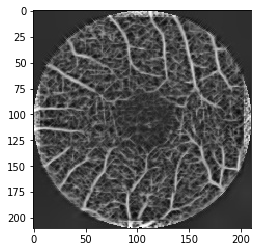

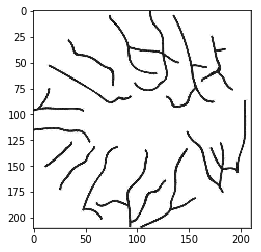

In [5]:
for i in range(len(masks)):
    img = cv2.imread(root_orig+masks[i])
    mask = cv2.imread(root_marked+masks[i])[...,2]
    mask = cv2.resize(mask, (210,210))
    print(img.shape)
    plt.imshow(img)
    plt.show()
    plt.imshow(mask, cmap='gray')
    plt.show()
    break

In [6]:
# img = get_line_arrays(90, 45, math.pi/4*0)
# for i in range(4):
#     img += get_line_arrays(90, 45, math.pi/4*i)
# #     plt.imshow(img)
# #     print(np.sum(img))
# #     plt.show()
# plt.imshow(img.clip(max = 1, min = 0))

In [7]:
def get_line_arrays(w, l, angle):
    window = (np.ones((w,w))*0).astype('uint8')
    mid_point = w//2
    l = l//2
    if((angle<math.pi/4) or (angle>math.pi/2+math.pi/4)):
        start_point = (int(mid_point+l), int(mid_point-l*math.tan(angle)))
        end_point = (int(mid_point-l), int(mid_point+l*math.tan(angle)))
    elif(angle==math.pi/2):
        start_point = (mid_point, int(mid_point+l))
        end_point = (mid_point, int(mid_point-l))
    elif(angle==math.pi/4):
        start_point = (int(l+mid_point), int(mid_point+l))
        end_point = (int(-l+mid_point), int(mid_point-l))
    elif(angle==math.pi/2+math.pi/4):
        start_point = (int(-l+mid_point), int(mid_point+l))
        end_point = (int(l+mid_point), int(mid_point-l))
    else:
        start_point = (int(l/math.tan(angle)+mid_point), int(mid_point+l))
        end_point = (int(mid_point-l/math.tan(angle)), int(mid_point-l))
    color = 1
    thickness = 1
    window = cv2.line(window, start_point, end_point, color, thickness)
    return window
    
def lineseg(image, w, l):
    img = image.copy()
    H, W = img.shape
    
    for i in range(w//2, W-w//2):
        for j in range(w//2, H-w//2):
            window = img[i-w//2:i+w//2+1, j-w//2:j+w//2+1]
            line_responses = []
            for k in range(4):
                window_k = get_line_arrays(w, l, math.pi/4*k)
                line_response = np.sum(window_k*window)/np.sum(window_k)
                line_responses.append(line_response)
            img[i, j] = max(line_responses) - np.mean(window)
    return img

def seg_img_multi(img, w_l = [(15, 3), (15, 7), (15, 11), (15, 15), (11, 3), (11, 7), (11, 11), (7, 3), (7,7), (3,3)]):
    temp = img
    img = np.zeros_like(temp, dtype = np.float32)
    for w_l_i in w_l:
        img += lineseg(temp/255., w_l_i[0], w_l_i[1])
    return img/(len(w_l)+1)

def knn(img_seg):
    img = img_seg*255
    # img = cv2.fastNlMeansDenoising(img,None,15,7,11) #mean denoising
    vectorized = img.reshape((-1,1))
    vectorized = np.float32(vectorized)
    criteria = (cv2.TERM_CRITERIA_EPS + cv2.TERM_CRITERIA_MAX_ITER, 10, 1.0)
    criteria = (cv2.TERM_CRITERIA_MAX_ITER,20000, 0.0001)
    K = 4
    attempts=100
    ret,label,center=cv2.kmeans(vectorized,K,None,criteria,attempts,cv2.KMEANS_RANDOM_CENTERS)
    center = np.uint8(center)
    res = center[label.flatten()]
    result_image = res.reshape((img.shape))
    return result_image

def standardize(img):
    return (img-img.min()/img.max()-img.min())

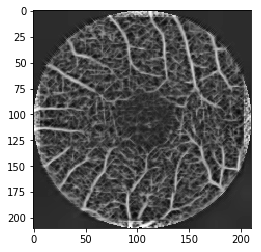

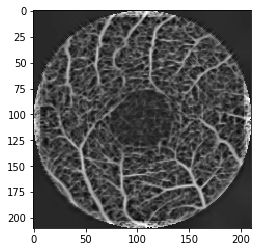

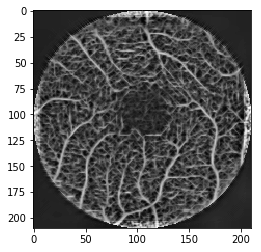

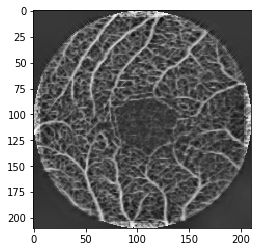

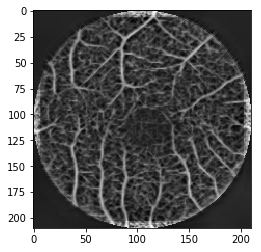

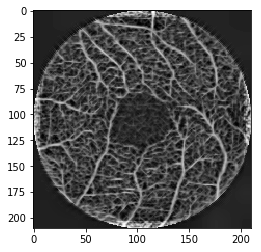

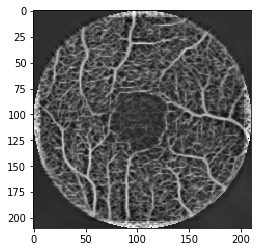

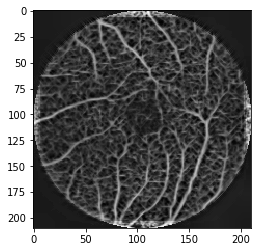

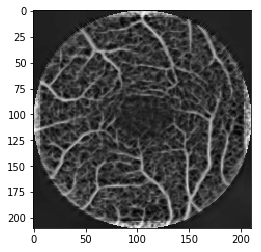

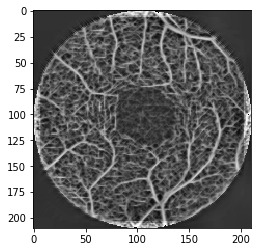

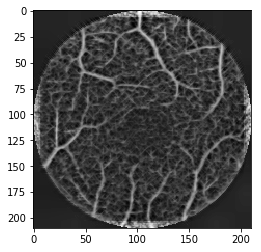

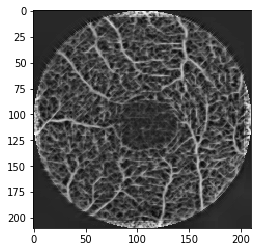

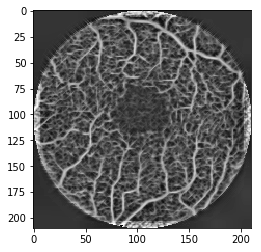

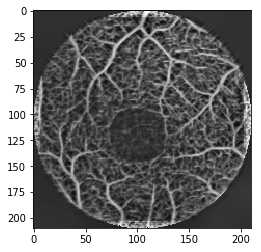

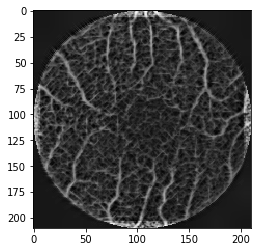

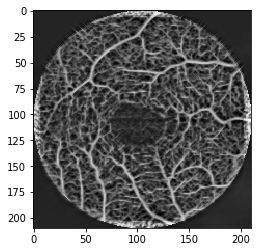

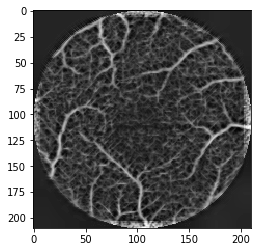

In [247]:
for i in range(len(masks)):
    img = cv2.imread(root_orig+masks[i])
    img_seg = seg_img_multi(img[...,0])
    img_segn = standardize(img_seg)
    clahe = cv2.createCLAHE(clipLimit=2.0, tileGridSize=(8,8))
    cl1 = clahe.apply((img_segn*255).round().astype('uint8'))
    cv2.imwrite('processed_images/'+masks[i], cl1)
    plt.imshow(cl1, cmap = 'gray')
    plt.show()

In [231]:
img_seg = seg_img_multi(img[...,0])
img_segn = standardize(img_seg)

In [232]:
clahe = cv2.createCLAHE(clipLimit=2.0, tileGridSize=(8,8))
cl1 = clahe.apply((img_segn*255).round().astype('uint8'))

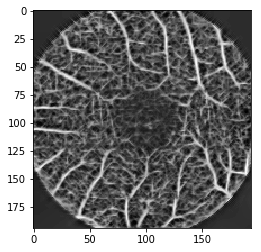

In [240]:
plt.imshow(cl1[8:-8,8:-8], cmap = 'gray')

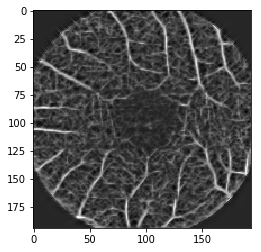

In [234]:
plt.imshow(img_seg[8:-8,8:-8], cmap = 'gray')

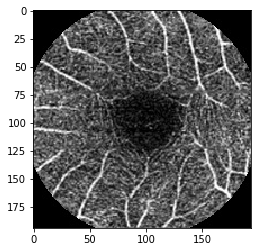

In [235]:
plt.imshow(img[8:-8,8:-8], cmap = 'gray')

In [8]:
def get_trans(phase):
    list_transforms = []
    if phase == "train":
        list_transforms.extend(
            [
             aug.Transpose(),
             aug.Flip(),
             aug.GaussianBlur(),
             aug.OneOf([
                 aug.RandomContrast(),
                 aug.RandomGamma(),
                 aug.RandomBrightness(),
                 ], p=1),
             aug.ShiftScaleRotate(rotate_limit=90),
             aug.GaussNoise(p=.5),
            ]
        )

    list_transforms.extend(
        [
            Resize(224, 224),
            ToTensor(),
        ]
    )
    list_trfms = Compose(list_transforms)
    return list_trfms

In [9]:
class EyeDataset(Dataset):
    def __init__(self, phase):
        self.fnames = os.listdir(root_marked)
        print(len(self.fnames))
        self.phase = phase
        self.transforms = get_trans(phase)

    def __getitem__(self, idx):
        if self.phase == 'train':
            img = cv2.imread(root_orig+self.fnames[idx])
            mask = cv2.imread(root_marked+self.fnames[idx])[...,0]
        else:
            img = cv2.imread(root_orig+self.fnames[idx+14])
            mask = cv2.imread(root_marked+self.fnames[idx+14])[...,0]
        mask = 1-mask
        if self.transforms is not None:    
            augmented = self.transforms(image=img.astype('uint8'), mask=(mask/255).round().astype('int'))
            img = augmented['image']
            mask = augmented['mask']
#             print(mask.shape)
            mask = mask
            
        return img, mask

    def __len__(self):
        if(self.phase == 'train'):
            return len(self.fnames)-3
        else:
            return 3

In [14]:
data = EyeDataset('train')

17


In [15]:
img, mask = data.__getitem__(0)

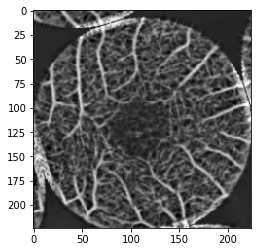

In [16]:
plt.imshow(img[0], cmap = 'gray')

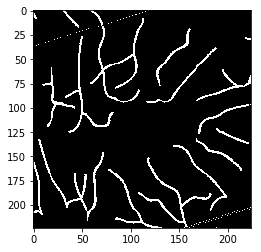

In [17]:
plt.imshow(mask[0], cmap = 'gray')

In [18]:
print(mask.max(), img.max())

tensor(1.) tensor(1.)


In [19]:
def provider(phase, batch_size=8, num_workers=4):
    '''Returns dataloader for the model training'''
    if phase == 'train': 
        shuffle = True
    else:
        shuffle = False
    image_dataset = EyeDataset(phase)    
    dataloader = DataLoader(
        image_dataset,
        batch_size=batch_size,
        num_workers=num_workers,
        pin_memory=True,
        shuffle=shuffle,   
    )

    return dataloader

In [20]:
class BCEDiceLoss(nn.Module):
    __name__ = 'bce_dice_loss'

    def __init__(self, eps=1e-7, beta=1., activation='sigmoid', ignore_channels=None, threshold=None):
        super().__init__()
        self.bce = nn.BCEWithLogitsLoss(reduction='mean')
        self.beta = beta
        self.eps = eps
        self.threshold = threshold
        self.ignore_channels = ignore_channels
        self.activation = smp.utils.base.Activation(activation)

    def forward(self, y_pr, y_gt):
        bce = self.bce(y_pr, y_gt)
        y_pr = self.activation(y_pr)
        dice = 1 - smp.utils.functional.f_score(
            y_pr, y_gt,
            beta=self.beta,
            eps=self.eps,
            threshold=self.threshold,
            ignore_channels=self.ignore_channels,
        )
        return dice + bce

class DiceLoss(nn.Module):
    __name__ = 'dice_loss'

    def __init__(self, eps=1e-7, beta=1., activation='sigmoid', ignore_channels=None, threshold=None):
        super().__init__()
        self.beta = beta
        self.eps = eps
        self.threshold = threshold
        self.ignore_channels = ignore_channels
        self.activation = smp.utils.base.Activation(activation)

    def forward(self, y_pr, y_gt):
        y_pr = self.activation(y_pr)
        dice = 1 - smp.utils.functional.f_score(
            y_pr, y_gt,
            beta=self.beta,
            eps=self.eps,
            threshold=self.threshold,
            ignore_channels=self.ignore_channels,
        )
        return dice

In [21]:
def single_dice_coef(y_true, y_pred_bin):
    # shape of y_true and y_pred_bin: (height, width)
    intersection = (y_true * y_pred_bin).sum()
    if (y_true.sum()==0 and y_pred_bin.sum()==0):
        return 1
    return (2*intersection) / (y_true.sum() + y_pred_bin.sum())


def dice_metric_train(y_pred_bin, y_true, threshold = 0.5):
    y_pred_bin = (y_pred_bin>threshold).float()
    y_true = y_true.float()
    batch_size = y_true.shape[0]
    channel_num = y_true.shape[1]
    mean_dice_channel = 0.
    for i in range(batch_size):
        for j in range(channel_num):
            channel_dice = single_dice_coef(y_true[i, j, ...],y_pred_bin[i, j, ...])
            mean_dice_channel += channel_dice/(channel_num*batch_size)
    return mean_dice_channel


def dice_metric(y_pred_bin, y_true, threshold = 0.5):
    y_pred_bin = (y_pred_bin>threshold).float().detach().cpu().numpy()
    y_true = y_true.float().detach().cpu().numpy()
    batch_size = y_true.shape[0]
    dice = []
    precision = []
    recall = []
    for i in range(batch_size):
        p, r, fb_score, support = precision_recall_fscore_support( ((y_true[i]> 0).astype(np.uint8)).flatten(), ((y_pred_bin[i]> 0).astype(np.uint8)).flatten(), average='binary')
        dice.append(fb_score)
        precision.append(p)
        recall.append(r)
    return np.mean(dice), np.mean(precision), np.mean(recall)


class Meter:
    '''A meter to keep track of iou and dice scores throughout an epoch'''
    def __init__(self, phase, epoch):
        self.base_threshold = 0.5 # <<<<<<<<<<< here's the threshold
        self.base_dice_scores = []
        self.phase = phase


    def update(self, targets, outputs):
        probs = torch.sigmoid(outputs)
        dice = dice_metric_train(probs, targets)
        self.base_dice_scores.append(dice)
        
    def get_metrics(self):
        dice = np.mean(self.base_dice_scores)
        return dice

def epoch_log(phase, epoch, epoch_loss, meter, start):
    '''logging the metrics at the end of an epoch'''
    dice = meter.get_metrics()
    print("Loss: %0.4f | dice: %0.4f" % (epoch_loss, dice))
    return dice

In [22]:
class Trainer(object):
    '''This class takes care of training and validation of our model'''
    def __init__(self,model, optim, loss, lr, bs, name):
        self.num_workers = 4
        self.batch_size = {"train": bs, "val": bs}
        self.accumulation_steps = bs // self.batch_size['train']
        self.lr = lr
        self.loss = loss
        self.optim = optim
        self.num_epochs = 0
        self.best_dice = 0.
        self.best_val_acc = 0
        self.phases = ["train", "val"]
        self.device = torch.device("cuda:0")
        torch.set_default_tensor_type("torch.cuda.FloatTensor")
        self.net = model
        self.name = name
        self.do_cutmix = True
        self.loss_classification = torch.nn.CrossEntropyLoss()
        if self.loss == 'BCE':
            self.criterion = torch.nn.BCEWithLogitsLoss()
        elif self.loss == 'BCE+DICE':
            self.criterion = BCEDiceLoss(threshold=None)  #MODIFIED
        elif self.loss == 'TVERSKY':
            self.criterion = Tversky()
        elif self.loss == 'Dice' or self.loss == 'DICE':
            self.criterion = DiceLoss()
        elif self.loss == 'BCE+DICE+JACCARD':
            self.criterion = BCEDiceJaccardLoss(threshold=None)
        else:
            raise(Exception(f'{self.loss} is not recognized. Please provide a valid loss function.'))

        # Optimizers
        if self.optim == 'Over9000':
            self.optimizer = Over9000(self.net.parameters(),lr=self.lr)
        elif self.optim == 'Adam':
            self.optimizer = torch.optim.Adam(self.net.parameters(),lr=self.lr)
        elif self.optim == 'RAdam':
            self.optimizer = Radam(self.net.parameters(),lr=self.lr)
        elif self.optim == 'Ralamb':
            self.optimizer = Ralamb(self.net.parameters(),lr=self.lr)
        elif self.optim == 'Ranger':
            self.optimizer = Ranger(self.net.parameters(),lr=self.lr)
        elif self.optim == 'LookaheadAdam':
            self.optimizer = LookaheadAdam(self.net.parameters(),lr=self.lr)
        else:
            raise(Exception(f'{self.optim} is not recognized. Please provide a valid optimizer function.'))
            
        self.scheduler = ReduceLROnPlateau(self.optimizer, factor=0.5, mode="min", patience=10, verbose=True, min_lr = 1e-5)
        self.net = self.net.to(self.device)
        cudnn.benchmark = True
        
        self.dataloaders = {
            phase: provider(
                phase=phase,
                batch_size=self.batch_size[phase],
                num_workers=self.num_workers,
            )
            for phase in self.phases
        }
        self.losses = {phase: [] for phase in self.phases}
        self.dice_scores = {phase: [] for phase in self.phases}
        self.acc_scores = {phase: [] for phase in self.phases}

    def freeze(self):
        for  name, param in self.net.encoder.named_parameters():
            if name.find('bn') != -1:
                param.requires_grad=True
            else:
                param.requires_grad=False
    
    def seed_everything(self,seed=43):
        random.seed(seed)
        np.random.seed(seed)
        os.environ['PYTHONHASHSEED'] = str(seed)
        torch.manual_seed(seed)

    def load_model(self, name, path='models/'):
        state = torch.load(path+name, map_location=lambda storage, loc: storage)
        self.net.load_state_dict(state['state_dict'])
        self.optimizer.load_state_dict(state['optimizer'])
        print("Loaded model with dice: ", state['best_dice'])
            
    def unfreeze(self):
        for param in self.net.parameters():
            param.requires_grad=True
     
    def forward(self, images, targets):
        images = images.to(self.device)
        masks = targets.to(self.device)
        outputs = self.net(images.type(torch.cuda.FloatTensor))
        loss = self.criterion(outputs, masks)
        return loss, outputs
    
    def cutmix(self,batch, alpha):
        data, targets = batch
        indices = torch.randperm(data.size(0))
        shuffled_data = data[indices]
        shuffled_targets = targets[indices]
        lam = np.random.beta(alpha, alpha)
        image_h, image_w = data.shape[2:]
        cx = np.random.uniform(0, image_w)
        cy = np.random.uniform(0, image_h)
        w = image_w * np.sqrt(1 - lam)
        h = image_h * np.sqrt(1 - lam)
        x0 = int(np.round(max(cx - w / 2, 0)))
        x1 = int(np.round(min(cx + w / 2, image_w)))
        y0 = int(np.round(max(cy - h / 2, 0)))
        y1 = int(np.round(min(cy + h / 2, image_h)))
        data[:, :, y0:y1, x0:x1] = shuffled_data[:, :, y0:y1, x0:x1]
        targets[:, :, y0:y1, x0:x1] = shuffled_targets[:, :, y0:y1, x0:x1]
        return data, targets

    def iterate(self, epoch, phase):
        meter = Meter(phase, epoch)
        start = time.strftime("%H:%M:%S")
        print(f"Starting epoch: {epoch} | phase: {phase} | ⏰: {start}")
        batch_size = self.batch_size[phase]
        dataloader = self.dataloaders[phase]
        running_loss = 0.0
        total_batches = len(dataloader)
        tk0 = tqdm(dataloader, total=total_batches)
        self.optimizer.zero_grad()
        for itr, batch in enumerate(tk0):
            if phase == "train" and self.do_cutmix:
                images, targets = self.cutmix(batch, 0.5)
            else:
                images, targets = batch
            seg_loss, outputs = self.forward(images, targets)
            loss = seg_loss / self.accumulation_steps
            if phase == "train":
                loss.backward()
                torch.nn.utils.clip_grad_norm_(self.net.parameters(), 1)
                if (itr + 1 ) % self.accumulation_steps == 0:
                    self.optimizer.step()
                    self.optimizer.zero_grad()
            running_loss += loss.item()
            outputs = outputs.detach().cpu()
            meter.update(targets, outputs)
            tk0.set_postfix(loss=(running_loss / ((itr + 1))))
        epoch_loss = (running_loss * self.accumulation_steps) / total_batches
        dice = epoch_log(phase, epoch, epoch_loss, meter, start)
        self.losses[phase].append(epoch_loss)
        self.dice_scores[phase].append(dice)
        torch.cuda.empty_cache()
        return epoch_loss, dice

    def train_end(self):
        train_dice = self.dice_scores["train"]
        train_loss = self.losses["train"]
        
        val_dice = self.dice_scores["val"]
        val_loss = self.losses["val"]

        df_data=np.array([train_loss,train_dice, val_loss,val_dice]).T
        df = pd.DataFrame(df_data,columns = ['train_loss','train_dice', 'val_loss','val_dice'])
        df.to_csv('logs/'+self.name+'.csv')

    def fit(self, epochs):
        self.num_epochs+=epochs
        for epoch in range(self.num_epochs-epochs, self.num_epochs):
            self.net.train()
            self.iterate(epoch, "train")
            state = {
                "epoch": epoch,
                "best_dice": self.best_dice,
                "best_acc": self.best_val_acc,
                "state_dict": self.net.state_dict(),
                "optimizer": self.optimizer.state_dict(),
            }
            self.net.eval()
            with torch.no_grad():
                val_loss, val_dice = self.iterate(epoch, "val")
                self.scheduler.step(val_loss)
            if val_dice > self.best_dice:
                print("* New optimal found according to dice, saving state *")
                state["best_dice"] = self.best_dice = val_dice
                os.makedirs('models/', exist_ok=True)
                torch.save(state, 'models/'+self.name+'_best_dice.pth')
            print()
            self.train_end()

In [23]:
import segmentation_models_pytorch as smp

In [30]:
smp.encoders.get_encoder_names()

['resnet18',
 'resnet34',
 'resnet50',
 'resnet101',
 'resnet152',
 'resnext50_32x4d',
 'resnext101_32x8d',
 'resnext101_32x16d',
 'resnext101_32x32d',
 'resnext101_32x48d',
 'dpn68',
 'dpn68b',
 'dpn92',
 'dpn98',
 'dpn107',
 'dpn131',
 'vgg11',
 'vgg11_bn',
 'vgg13',
 'vgg13_bn',
 'vgg16',
 'vgg16_bn',
 'vgg19',
 'vgg19_bn',
 'senet154',
 'se_resnet50',
 'se_resnet101',
 'se_resnet152',
 'se_resnext50_32x4d',
 'se_resnext101_32x4d',
 'densenet121',
 'densenet169',
 'densenet201',
 'densenet161',
 'inceptionresnetv2',
 'inceptionv4',
 'efficientnet-b0',
 'efficientnet-b1',
 'efficientnet-b2',
 'efficientnet-b3',
 'efficientnet-b4',
 'efficientnet-b5',
 'efficientnet-b6',
 'efficientnet-b7',
 'mobilenet_v2',
 'xception']

In [33]:
MODEL = 'FPN'
ENCODER = 'densenet121'
if(MODEL == 'Unet'):
    model = smp.Unet(ENCODER, encoder_weights='imagenet', classes=1, activation=None, in_channels=3)
elif(MODEL == 'FPN'):
    model = smp.FPN(ENCODER, encoder_weights='imagenet', classes=1, activation=None, in_channels=3)

In [ ]:
trainer = Trainer(model = model, optim = 'Ranger', loss = 'BCE', lr = 1e-3, bs = 128, name ='fpn-bce-b4')
trainer.seed_everything(42)
trainer.do_cutmix = False
trainer.freeze()
trainer.fit(5)
trainer.load_model('fpn-bce-vgg19_bn_best_dice.pth', path='models/')
trainer.do_cutmix = True
trainer.unfreeze()
trainer.fit(20)
trainer.load_model('fpn-bce-vgg19_bn_best_dice.pth', path='models/')
trainer.do_cutmix = False
trainer.unfreeze()
trainer.fit(5)

17
17
Starting epoch: 0 | phase: train | ⏰: 18:40:32



Loss: 1.8660 | dice: 0.1353
Starting epoch: 0 | phase: val | ⏰: 18:40:34



Loss: 1.1576 | dice: 0.1178
* New optimal found according to dice, saving state *

Starting epoch: 1 | phase: train | ⏰: 18:40:35


In [ ]:
trainer.best_dice

In [ ]:
dataset = EyeDataset('val')
dataloader = DataLoader(
        dataset,
        batch_size=128,
        num_workers=4,
        pin_memory=True,
        shuffle=False,
)

In [30]:
def predict(dataloader):
    total_batches = len(dataloader)
    tk0 = tqdm(dataloader, total=total_batches)
    for itr, batch in enumerate(tk0):
        images, targets = batch
        images = images.cuda()
        targets = targets.cuda()
        outputs = model(images.type(torch.cuda.FloatTensor))
    outputs = outputs.detach().cpu().numpy()
    outputs = 1/(1+np.exp(-1*outputs))
    for mask in outputs:
        plt.imshow(mask[0]>0.5, cmap = 'gray')
        plt.show()

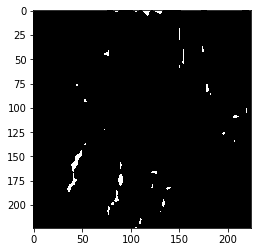

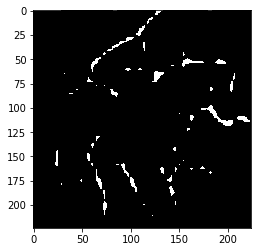

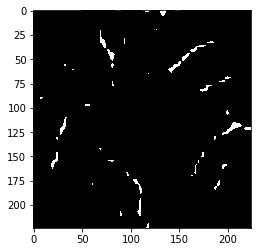

In [31]:
predict(dataloader)

In [24]:
# !sudo shutdown -h now

In [25]:
# mask = cv2.imread(masks[15])

In [26]:
# np.unique(mask[: :, 1])

In [27]:
# plt.imshow(mask)

In [28]:
# import segmentation_models_pytorch as smp

In [29]:
# if(MODEL == 'Unet'):
#         model = smp.Unet(ENCODER, encoder_weights='imagenet', classes=5, activation=None)
#     elif(MODEL == 'FPN'):
#         model = smp.FPN(ENCODER, encoder_weights='imagenet', classes=5, activation=None)
#     elif(MODEL == 'Linknet'):
#         model = smp.Linknet(ENCODER, encoder_weights='imagenet', classes=5, activation=None)
    
#     model_trainer = Trainer(model = model, optim = OPTIMIZER, loss = LOSS, lr = 1e-3, bs = 8, name = ENCODER+'_'+MODEL+'_'+LOSS+'_'+OPTIMIZER)
#     model_trainer.seed_everything(43)
#     model_trainer.do_cutmix = False
#     model_trainer.freeze()
#     model_trainer.change_loader(crop_type=0, shape=512)
#     model_trainer.fit(10)
#     model_trainer.do_cutmix = True
#     model_trainer.unfreeze()
#     model_trainer.change_loader(crop_type=0, shape=512)
#     model_trainer.fit(20)
#     model_trainer.do_cutmix = True
#     model_trainer.unfreeze()
#     model_trainer.change_loader(crop_type=1, shape=512)
#     model_trainer.fit(20)
#     model_trainer.do_cutmix = False
#     model_trainer.freeze()
#     model_trainer.change_loader(crop_type=1, shape=512)
#     model_trainer.fit(5)